In [1]:
import numpy as np
import pandas as pd

In [2]:
%pip install scipy
%pip install datetime

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

def parse_mixed_dates(series):
    s = series.astype(str).str.strip()

    # Try first format: YYYY-MM-DD
    d1 = pd.to_datetime(s, format='%Y-%m-%d', errors='coerce')

    # Try second format: MM/DD/YYYY (where first attempt failed)
    mask = d1.isna()
    d2 = pd.to_datetime(s[mask], format='%m/%d/%Y', errors='coerce')

    # Fill missing values from second parse
    d1[mask] = d2

    return d1


# Load SOI
soi = pd.read_csv(
    r"C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\ENSO\soi.long.csv"
)

# Normalize column names
soi.columns = soi.columns.str.strip()

# Convert date column to datetime
soi['Date'] = parse_mixed_dates(soi['Date'])

# Remove missing values
soi = soi[soi['SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/'] != -9999.00]

# Set index
soi = soi.set_index('Date')


# Load PDO
pdo = pd.read_csv(
    r"C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\PDO\pdo.timeseries.ersstv5.csv"
)

# Normalize column names
pdo.columns = pdo.columns.str.strip()

# Convert date column
pdo['Date'] = parse_mixed_dates(pdo['Date'])

pdo = pdo[pdo['PDO from ERSST V5 https://psl.noaa.gov/pdo/ Using EOF from 1920 to 2014 for N Pacific (see webpage)'] != -9999.00]

pdo = pdo.set_index('Date')


# Rename for clarity
soi = soi.rename(columns={'SOI from CRU  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/': 'SOI'})
pdo = pdo.rename(columns={'PDO from ERSST V5 https://psl.noaa.gov/pdo/ Using EOF from 1920 to 2014 for N Pacific (see webpage)': 'PDO'})


# Merge on datetime index
df = soi.join(pdo, how='inner')

print(df)


             SOI    PDO
Date                   
1866-01-01 -0.62 -1.735
1866-02-01 -0.12 -1.599
1866-03-01 -0.62 -1.550
1866-04-01 -0.65 -0.760
1866-05-01  0.04 -0.294
...          ...    ...
2025-03-01  0.88 -0.889
2025-04-01  0.47 -1.015
2025-05-01  0.42 -1.595
2025-06-01  0.16 -2.653
2025-07-01  0.70 -3.542

[1915 rows x 2 columns]


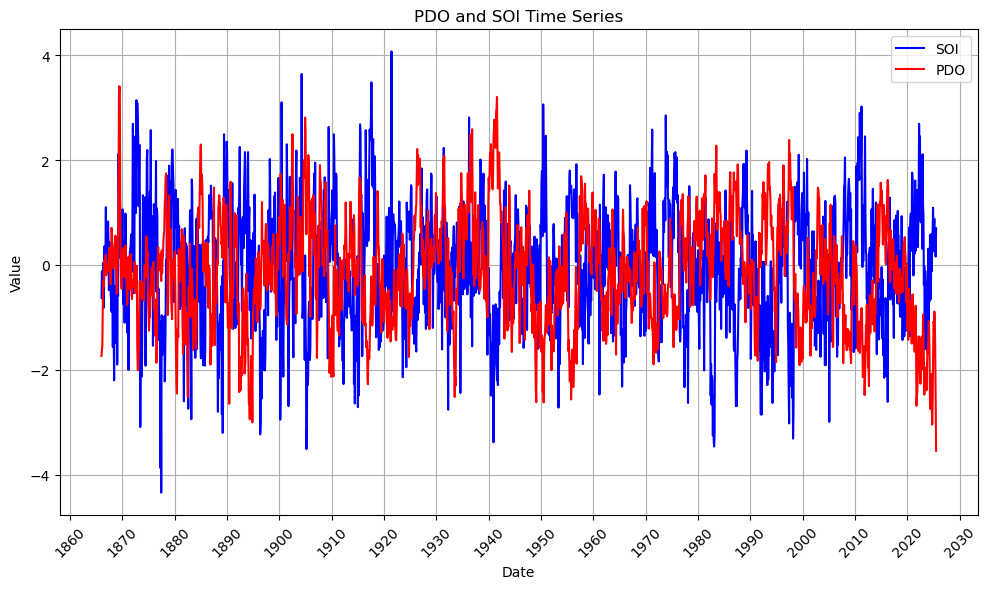

In [4]:
import matplotlib.pyplot as plt
import datetime as datetime
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df.index, df['SOI'], label='SOI', color='blue')
ax.plot(df.index, df['PDO'], label='PDO', color='red')

# --- Add 100-year ticks ---
ax.xaxis.set_major_locator(mdates.YearLocator(10))   # tick every 100 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optional (rotate labels)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_title('PDO and SOI Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(True)
ax.legend()

plt.tight_layout()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\indes.png')
plt.show()


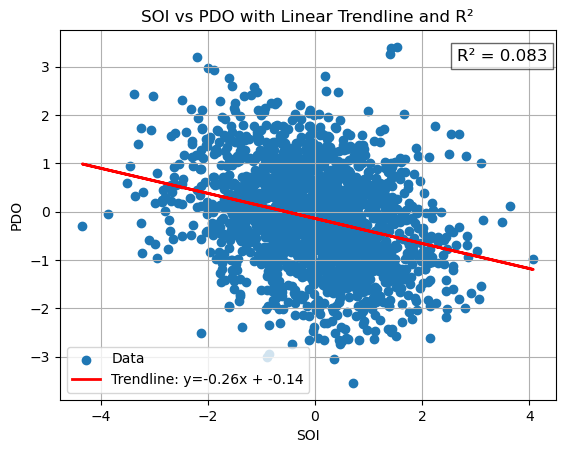

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Remove NaNs
df_clean = df[['SOI','PDO']].dropna()

x = df_clean['SOI']
y = df_clean['PDO']

# Fit linear regression (y = m*x + b)
m, b = np.polyfit(x, y, 1)

# Compute R²
y_pred = m * x + b
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# Plot scatter
plt.scatter(x, y, label='Data')

# Plot trendline
plt.plot(x, y_pred, linewidth=2, label=f'Trendline: y={m:.2f}x + {b:.2f}', color = 'red')

# Add R² to the plot
plt.text(
    0.80, 0.95,
    f"R² = {r2:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6)
)

plt.xlabel('SOI')
plt.ylabel('PDO')
plt.title('SOI vs PDO with Linear Trendline and R²')
plt.grid(True)
plt.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\index_cor.png')
plt.show()


In [6]:
# auto-correlations
for col in df_clean.columns:
    ac = df_clean[col].autocorr(lag = 120)
    print(f'{col}:{ac}')

SOI:-0.00276640449880927
PDO:0.026165051890087918


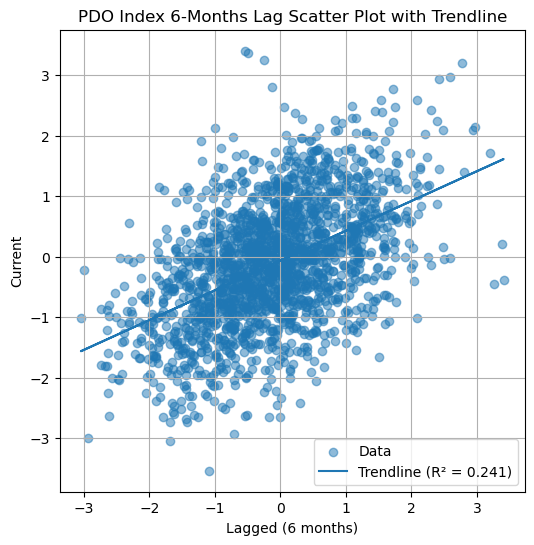

In [7]:
# pdo - 6 month cor
# Pick your variable
s = df_clean['PDO']  # or precipitation

# Create 1-year lag
lagged = s.shift(6)

# Combine and drop missing values
df = pd.DataFrame({'current': s, 'lagged': lagged}).dropna()

x = df['lagged']
y = df['current']

# ---- Fit linear regression for trendline ----
coeffs = np.polyfit(x, y, deg=1)   # slope, intercept
trendline = np.poly1d(coeffs)

# Compute R²
y_pred = trendline(x)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5, label='Data')

# Trendline plot
plt.plot(x, trendline(x), label=f'Trendline (R² = {r2:.3f})')

plt.xlabel('Lagged (6 months)')
plt.ylabel('Current')
plt.title('PDO Index 6-Months Lag Scatter Plot with Trendline')
plt.legend()
plt.grid(True)
plt.show()



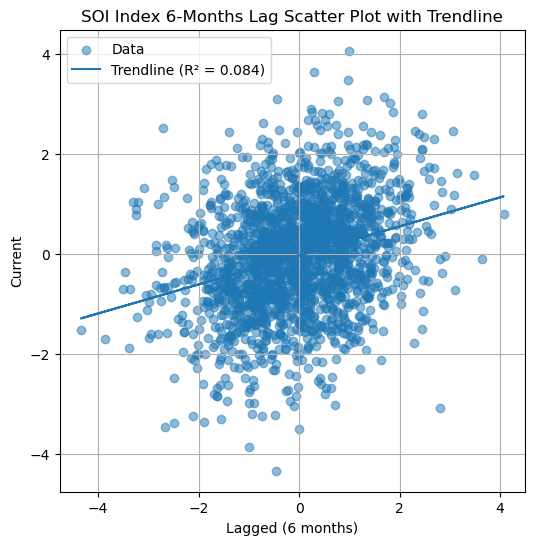

In [8]:
# pdo - 6 month cor
# Pick your variable
s = df_clean['SOI']  # or precipitation

# Create 1-year lag
lagged = s.shift(6)

# Combine and drop missing values
df = pd.DataFrame({'current': s, 'lagged': lagged}).dropna()

x = df['lagged']
y = df['current']

# ---- Fit linear regression for trendline ----
coeffs = np.polyfit(x, y, deg=1)   # slope, intercept
trendline = np.poly1d(coeffs)

# Compute R²
y_pred = trendline(x)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5, label='Data')

# Trendline plot
plt.plot(x, trendline(x), label=f'Trendline (R² = {r2:.3f})')

plt.xlabel('Lagged (6 months)')
plt.ylabel('Current')
plt.title('SOI Index 6-Months Lag Scatter Plot with Trendline')
plt.legend()
plt.grid(True)
plt.show()



In [9]:
# import temperature and preciptation data
climate = pd.read_csv(r"C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\climate\avg_precip_temp.csv", index_col = 'Row Labels')
climate = climate.iloc[:-2]
climate.index = pd.to_datetime(climate.index, format='%m/%d/%Y')
print(climate)

            Average of Total Precip (in)  Average of Avg Air Temp (F)
Row Labels                                                           
1982-06-01                      0.060000                    72.200000
1982-07-01                      0.080000                    77.200000
1982-08-01                      0.000000                    76.750000
1982-09-01                      1.063333                    67.066667
1982-10-01                      1.370000                    62.666667
...                                  ...                          ...
2025-07-01                      0.000000                    76.376190
2025-08-01                      0.007619                    78.766667
2025-09-01                      0.230952                    74.628571
2025-10-01                      1.307619                    62.219048
2025-11-01                      2.434762                    55.509524

[522 rows x 2 columns]


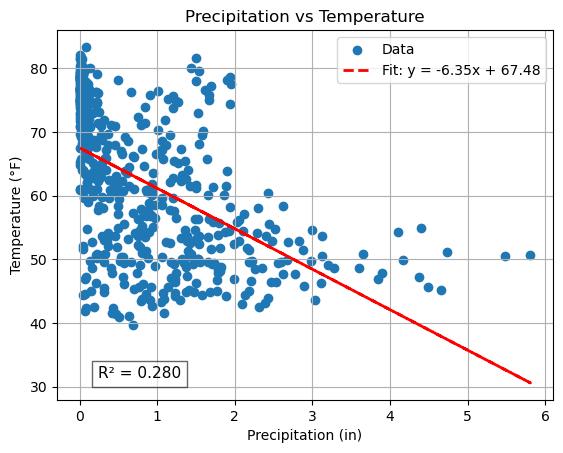

In [43]:
# temperature and precipitation scatter plot
import numpy as np
import matplotlib.pyplot as plt

# data cleaning (repeat from above)
x = pd.to_numeric(climate['Average of Total Precip (in)'], errors='coerce')
y = pd.to_numeric(climate['Average of Avg Air Temp (F)'], errors='coerce')
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask].astype(np.float64)
y = y[mask].astype(np.float64)

x_mean = x.mean()
x_centered = x - x_mean
m_c, b_c = np.polyfit(x_centered, y, 1)
m = m_c
b = b_c - m * x_mean
y_fit = m * x + b
r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - y.mean())**2)

plt.scatter(x, y, label='Data')
plt.plot(x, y_fit, 'r--', linewidth=2, label=f'Fit: y = {m:.2f}x + {b:.2f}')
plt.xlabel('Precipitation (in)')
plt.ylabel('Temperature (°F)')
plt.title('Precipitation vs Temperature')
plt.legend(loc='upper right')

# R^2 in bottom-right
plt.text(0.25, 0.05, f"R² = {r2:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))

plt.grid(True)
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\precip_temp_corr.png')
plt.show()


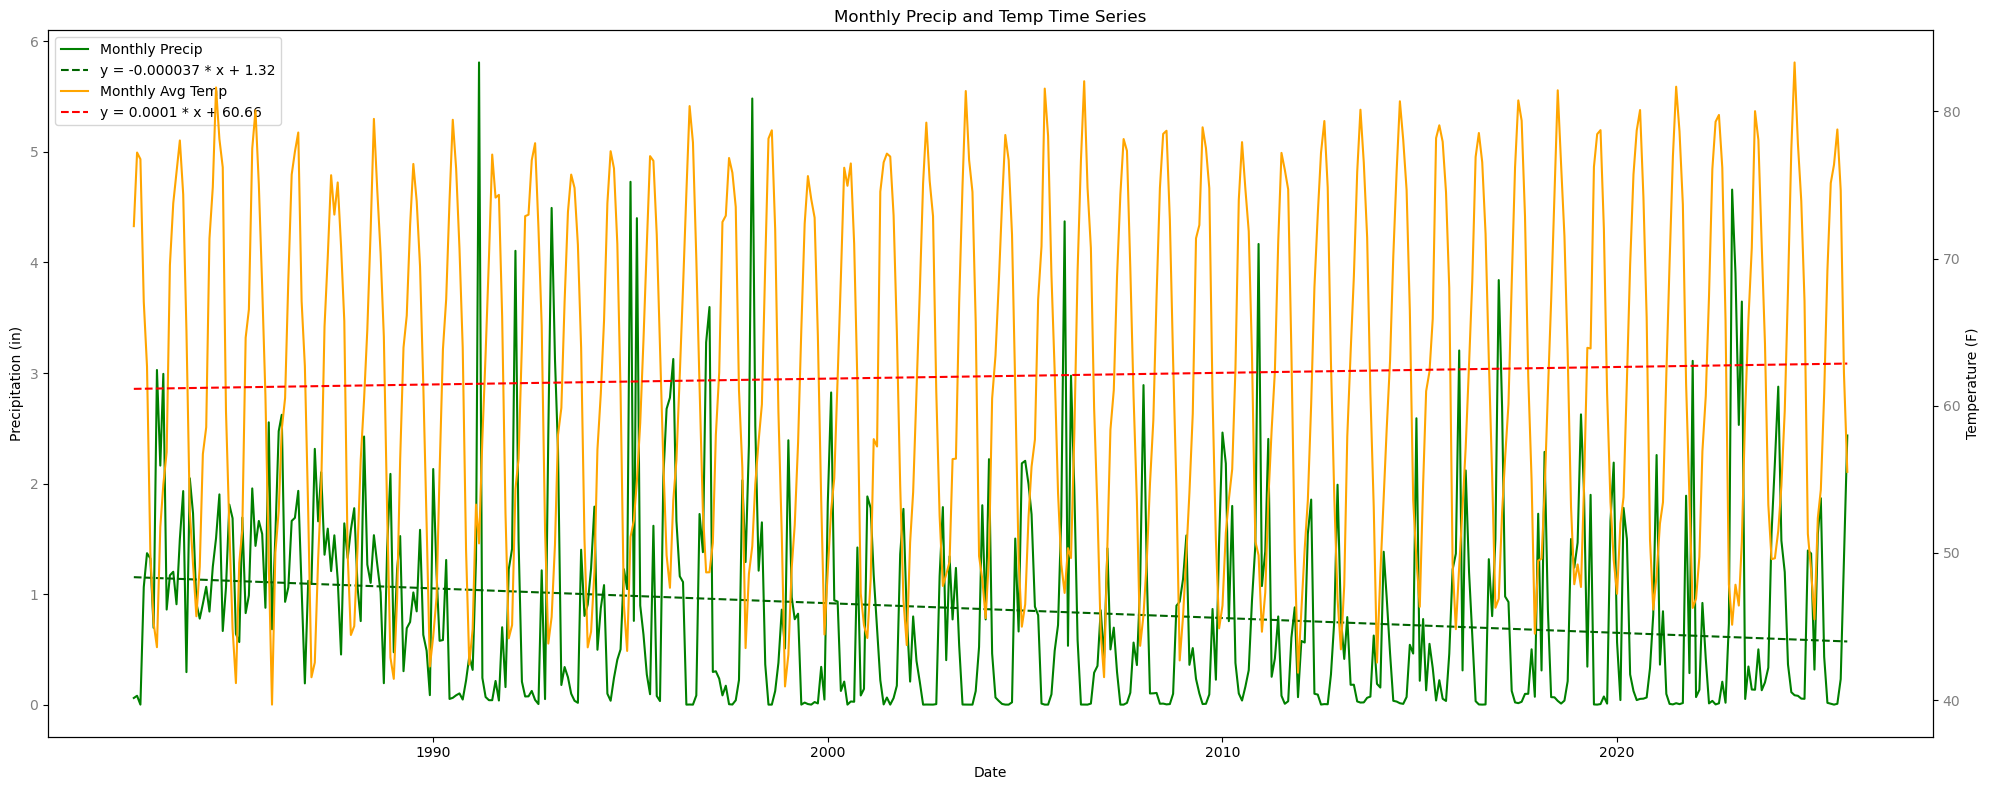

In [11]:
# temperature and precipitation time series

import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20, 8))

# --- Prep x-values as numeric for regression ---
x = mdates.date2num(climate.index)           # convert datetime index → float
# x_norm = x - x.min()                         # normalize to reduce numerical error

# --- Precipitation ---
y_precip = climate['Average of Total Precip (in)']

# Fit linear trendline
coef_precip = np.polyfit(x, y_precip, 1)
trend_precip = np.polyval(coef_precip, x)

# Compute R²
ss_res_p = np.sum((y_precip - trend_precip)**2)
ss_tot_p = np.sum((y_precip - np.mean(y_precip))**2)
r2_precip = 1 - ss_res_p / ss_tot_p

ax1.plot(climate.index, y_precip, label='Monthly Precip', color='green')
ax1.plot(climate.index, trend_precip, '--', color='darkgreen',  label = f'y = {coef_precip[0]:.6f} * x + {coef_precip[1]:.2f}')

ax1.set_title('Monthly Precip and Temp Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (in)')
ax1.tick_params(axis='y', labelcolor='grey')

# --- Set tick every 10 years ---
ax1.xaxis.set_major_locator(mdates.YearLocator(10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Temperature ---
ax2 = ax1.twinx()
y_temp = climate['Average of Avg Air Temp (F)']

coef_temp = np.polyfit(x, y_temp, 1)
trend_temp = np.polyval(coef_temp, x)

# Compute R²
ss_res_t = np.sum((y_temp - trend_temp)**2)
ss_tot_t = np.sum((y_temp - np.mean(y_temp))**2)
r2_temp = 1 - ss_res_t / ss_tot_t

ax2.plot(climate.index, y_temp, label='Monthly Avg Temp', color='orange')
ax2.plot(climate.index, trend_temp , '--', color='red', label = f'y = {coef_temp[0]:.4f} * x + {coef_temp[1]:.2f}')

ax2.set_ylabel('Temperature (F)')
ax2.tick_params(axis='y', labelcolor='grey')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\precip_temp.png')
plt.show()


In [12]:
# auto-correlations
for col in climate.columns:
    ac = climate[col].autocorr(lag = 12)
    print(f'12 - Month Auto Correlation of {col}:{ac}')

12 - Month Auto Correlation of Average of Total Precip (in):0.38711775433898576
12 - Month Auto Correlation of Average of Avg Air Temp (F):0.9636934629314007


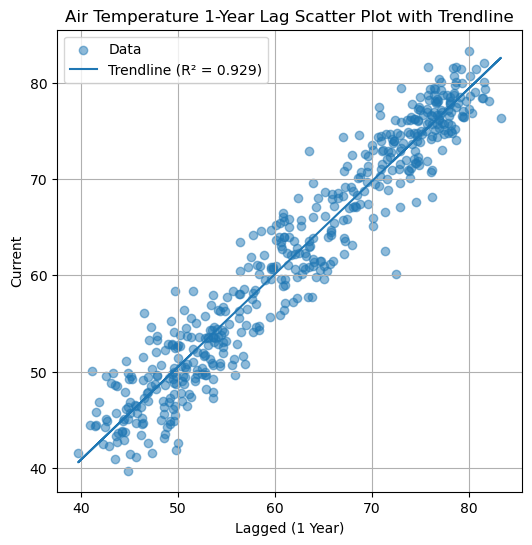

In [13]:
# temperature lag

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Pick your variable
s = climate['Average of Avg Air Temp (F)']  # or precipitation

# Create 1-year lag
lagged = s.shift(12)

# Combine and drop missing values
df = pd.DataFrame({'current': s, 'lagged': lagged}).dropna()

x = df['lagged']
y = df['current']

# ---- Fit linear regression for trendline ----
coeffs = np.polyfit(x, y, deg=1)   # slope, intercept
trendline = np.poly1d(coeffs)

# Compute R²
y_pred = trendline(x)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5, label='Data')

# Trendline plot
plt.plot(x, trendline(x), label=f'Trendline (R² = {r2:.3f})')

plt.xlabel('Lagged (1 Year)')
plt.ylabel('Current')
plt.title('Air Temperature 1-Year Lag Scatter Plot with Trendline')
plt.legend()
plt.grid(True)
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\temp_lag.png')
plt.show()



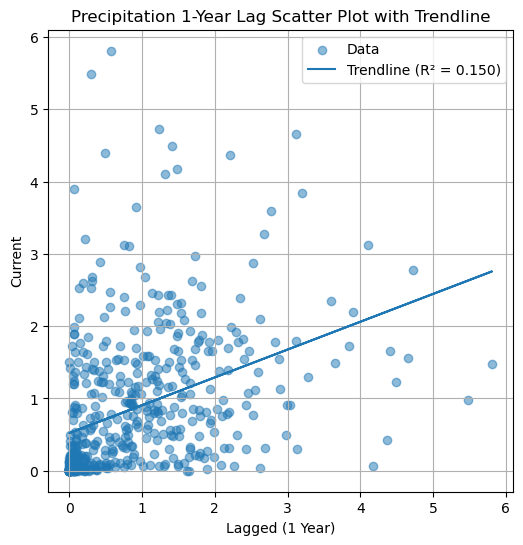

In [14]:
# precipiation lag

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Pick your variable
p = climate['Average of Total Precip (in)']  # or precipitation

# Create 1-year lag
lagged = p.shift(12)

# Combine and drop missing values
df = pd.DataFrame({'current': p, 'lagged': lagged}).dropna()

x = df['lagged']
y = df['current']

# ---- Fit linear regression for trendline ----
coeffs = np.polyfit(x, y, deg=1)   # slope, intercept
trendline = np.poly1d(coeffs)

# Compute R²
y_pred = trendline(x)
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# ---- Plot ----
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5, label='Data')

# Trendline plot
plt.plot(x, trendline(x), label=f'Trendline (R² = {r2:.3f})')

plt.xlabel('Lagged (1 Year)')
plt.ylabel('Current')
plt.title('Precipitation 1-Year Lag Scatter Plot with Trendline')
plt.legend()
plt.grid(True)
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\precip_lag.png')
plt.show()



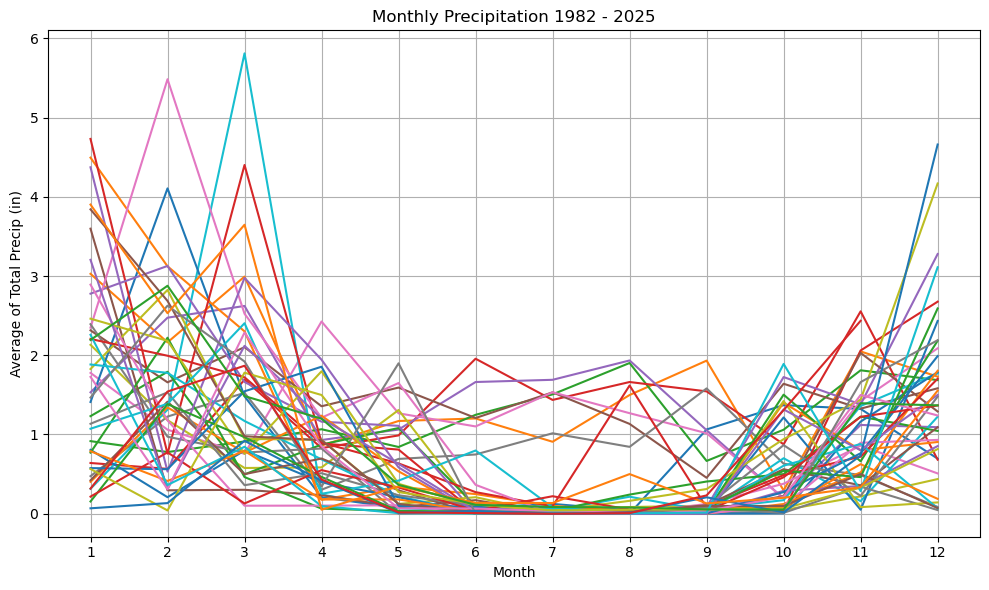

In [15]:
# Plotting Monthly Variations of Each year
data = climate
data['Year'] = data.index.year
data['Month'] = data.index.month
pivot = data.pivot_table(values = 'Average of Total Precip (in)', index = 'Month', columns = 'Year')
plt.figure(figsize = (10,6))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], label = str(year))

plt.xlabel("Month")
plt.ylabel("Average of Total Precip (in)")
plt.title("Monthly Precipitation 1982 - 2025")
plt.xticks(range(1,13))
# plt.legend(title = "Year")
plt.grid(True)
plt.tight_layout()
plt.show()

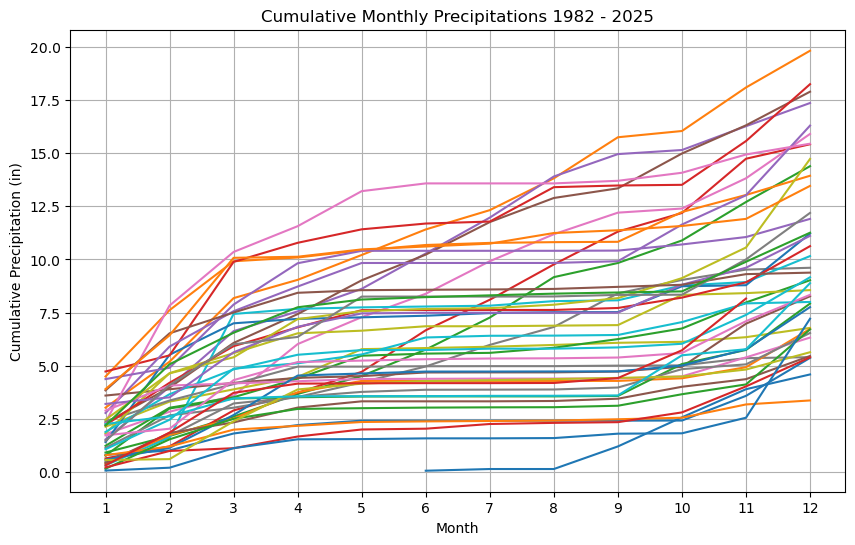

In [16]:
# cumulative precip
data = data.sort_values(['Year','Month'])
data['cum_value'] = data.groupby('Year')['Average of Total Precip (in)'].cumsum()
pivot = data.pivot_table(
    values="cum_value",
    index="Month",
    columns="Year"
)

plt.figure(figsize=(10,6))

for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], label=str(year))

plt.xlabel("Month")
plt.ylabel("Cumulative Precipitation (in)")
plt.title("Cumulative Monthly Precipitations 1982 - 2025")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()


In [17]:
print(data)

            Average of Total Precip (in)  Average of Avg Air Temp (F)  Year  \
Row Labels                                                                    
1982-06-01                      0.060000                    72.200000  1982   
1982-07-01                      0.080000                    77.200000  1982   
1982-08-01                      0.000000                    76.750000  1982   
1982-09-01                      1.063333                    67.066667  1982   
1982-10-01                      1.370000                    62.666667  1982   
...                                  ...                          ...   ...   
2025-07-01                      0.000000                    76.376190  2025   
2025-08-01                      0.007619                    78.766667  2025   
2025-09-01                      0.230952                    74.628571  2025   
2025-10-01                      1.307619                    62.219048  2025   
2025-11-01                      2.434762            

In [18]:
#  combinint both df_clean and climate

combined = df_clean.join(climate, how = 'inner')
print(combined)

             SOI    PDO  Average of Total Precip (in)  \
1982-06-01 -2.49 -0.501                      0.060000   
1982-07-01 -1.89  0.576                      0.080000   
1982-08-01 -2.66  0.397                      0.000000   
1982-09-01 -2.12  0.883                      1.063333   
1982-10-01 -2.20  0.441                      1.370000   
...          ...    ...                           ...   
2025-03-01  0.88 -0.889                      1.867619   
2025-04-01  0.47 -1.015                      0.431905   
2025-05-01  0.42 -1.595                      0.016190   
2025-06-01  0.16 -2.653                      0.008095   
2025-07-01  0.70 -3.542                      0.000000   

            Average of Avg Air Temp (F)  Year  Month  
1982-06-01                    72.200000  1982      6  
1982-07-01                    77.200000  1982      7  
1982-08-01                    76.750000  1982      8  
1982-09-01                    67.066667  1982      9  
1982-10-01                    62.666667 

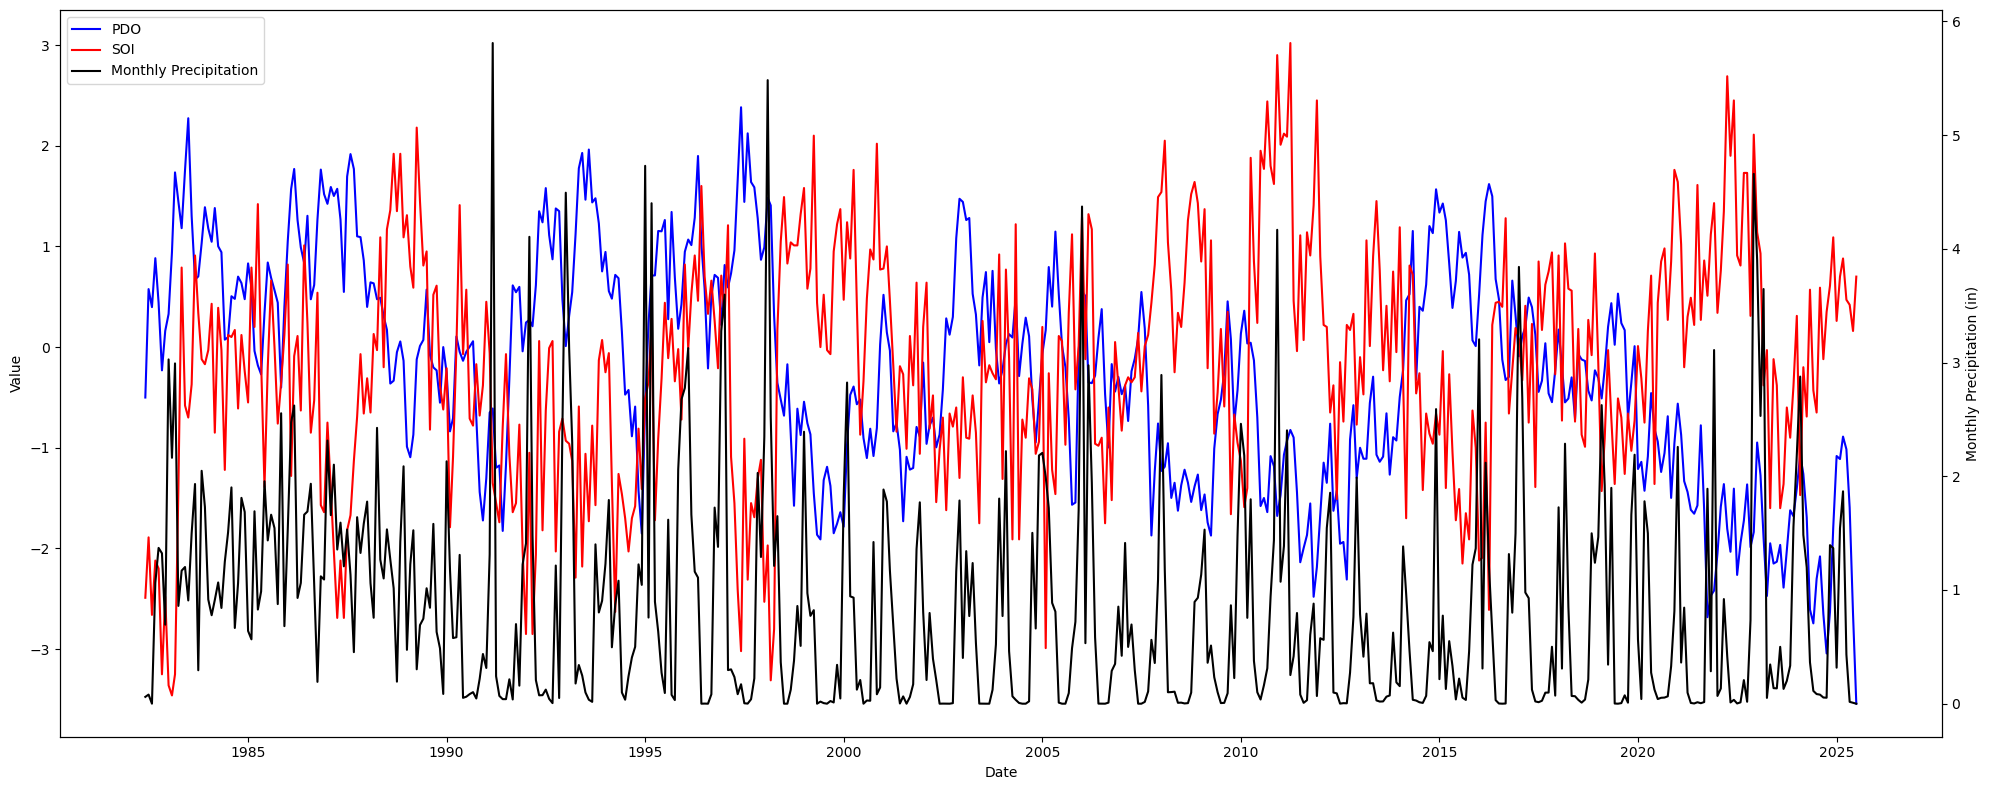

In [19]:
# more time series - SOI and PDO vs. precipitation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax1 = plt.subplots(figsize = (20, 8))
ax1.plot(combined.index, combined['PDO'], label = 'PDO', color = 'blue')
ax1.plot(combined.index, combined['SOI'], label = 'SOI', color = 'red')
ax1.set_ylabel('Value')
ax1.set_xlabel('Date')
# --- Set tick every 10 years ---
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax2 = ax1.twinx()
ax2.plot(combined.index, combined['Average of Total Precip (in)'], label = 'Monthly Precipitation', color = 'black')
ax2.set_ylabel('Monthly Precipitation (in)')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()

plt.show()

In [21]:
# lagged indexes
pdo_lagged_six = combined['PDO'].shift(6)
pdo_lagged_six = pdo_lagged_six.rename('PDO 6-Month Lag')
soi_lagged_six = combined['SOI'].shift(6)
soi_lagged_six = soi_lagged_six.rename('SOI 6-Month Lag')
lagged = pd.merge(pdo_lagged_six, soi_lagged_six, left_index = True, right_index = True, how = 'outer')
lagged['PDO 12-Month Lag'] = combined['PDO'].shift(12)
lagged['PDO 24-Month Lag'] = combined['PDO'].shift(24)
lagged['PDO 36-Month Lag'] = combined['PDO'].shift(36)
lagged['PDO 60-Month Lag'] = combined['PDO'].shift(60)
lagged['PDO 120-Month Lag'] = combined['PDO'].shift(120)
lagged['SOI 12-Month Lag'] = combined['SOI'].shift(12)
lagged['SOI 24-Month Lag'] = combined['SOI'].shift(24)
lagged['SOI 36-Month Lag'] = combined['SOI'].shift(36)
lagged['SOI 60-Month Lag'] = combined['SOI'].shift(60)
lagged['SOI 120-Month Lag'] = combined['SOI'].shift(120)
print(lagged)

            PDO 6-Month Lag  SOI 6-Month Lag  PDO 12-Month Lag  \
1982-06-01              NaN              NaN               NaN   
1982-07-01              NaN              NaN               NaN   
1982-08-01              NaN              NaN               NaN   
1982-09-01              NaN              NaN               NaN   
1982-10-01              NaN              NaN               NaN   
...                     ...              ...               ...   
2025-03-01           -2.651            -0.12            -1.261   
2025-04-01           -3.043             0.35            -1.691   
2025-05-01           -2.629             0.61            -2.607   
2025-06-01           -1.791             1.09            -2.744   
2025-07-01           -1.082             0.26            -2.303   

            PDO 24-Month Lag  PDO 36-Month Lag  PDO 60-Month Lag  \
1982-06-01               NaN               NaN               NaN   
1982-07-01               NaN               NaN               NaN   
198

# I chose 6 month as the lag time simply because it gives better correlation with precipitation duh. Temperature is WAY different

In [22]:
# now combine the lagged series with the previously combined data
lagged_combined = pd.merge(combined, lagged, left_index = True, right_index = True, how = 'inner')
lagged_combined['Precip 12-Month Lag'] = lagged_combined['Average of Total Precip (in)'].shift(12)
lagged_combined['Avg Temp 12-Month Lag'] = lagged_combined['Average of Avg Air Temp (F)'].shift(12)
print(lagged_combined)

             SOI    PDO  Average of Total Precip (in)  \
1982-06-01 -2.49 -0.501                      0.060000   
1982-07-01 -1.89  0.576                      0.080000   
1982-08-01 -2.66  0.397                      0.000000   
1982-09-01 -2.12  0.883                      1.063333   
1982-10-01 -2.20  0.441                      1.370000   
...          ...    ...                           ...   
2025-03-01  0.88 -0.889                      1.867619   
2025-04-01  0.47 -1.015                      0.431905   
2025-05-01  0.42 -1.595                      0.016190   
2025-06-01  0.16 -2.653                      0.008095   
2025-07-01  0.70 -3.542                      0.000000   

            Average of Avg Air Temp (F)  Year  Month  PDO 6-Month Lag  \
1982-06-01                    72.200000  1982      6              NaN   
1982-07-01                    77.200000  1982      7              NaN   
1982-08-01                    76.750000  1982      8              NaN   
1982-09-01             

In [23]:
# Now I need to split data into training and validation models
split_year = 2020
training = lagged_combined[lagged_combined.index.year <= split_year]
validation = lagged_combined[lagged_combined.index.year > split_year]

In [25]:
# correlation matrix
cor_matrix = training.corr()
print(cor_matrix)

                                   SOI       PDO  \
SOI                           1.000000 -0.428516   
PDO                          -0.428516  1.000000   
Average of Total Precip (in) -0.045093  0.191823   
Average of Avg Air Temp (F)  -0.065230  0.057027   
Year                          0.189219 -0.378991   
Month                         0.051773 -0.095281   
PDO 6-Month Lag              -0.283038  0.574345   
SOI 6-Month Lag               0.321142 -0.392911   
PDO 12-Month Lag             -0.098324  0.399270   
PDO 24-Month Lag             -0.016108  0.175550   
PDO 36-Month Lag              0.149728  0.023117   
PDO 60-Month Lag             -0.042749  0.018684   
PDO 120-Month Lag            -0.211767  0.372102   
SOI 12-Month Lag              0.066541 -0.270270   
SOI 24-Month Lag             -0.061262 -0.157153   
SOI 36-Month Lag              0.077676 -0.136877   
SOI 60-Month Lag              0.006130 -0.053031   
SOI 120-Month Lag             0.239040 -0.216141   
Precip 12-Mo

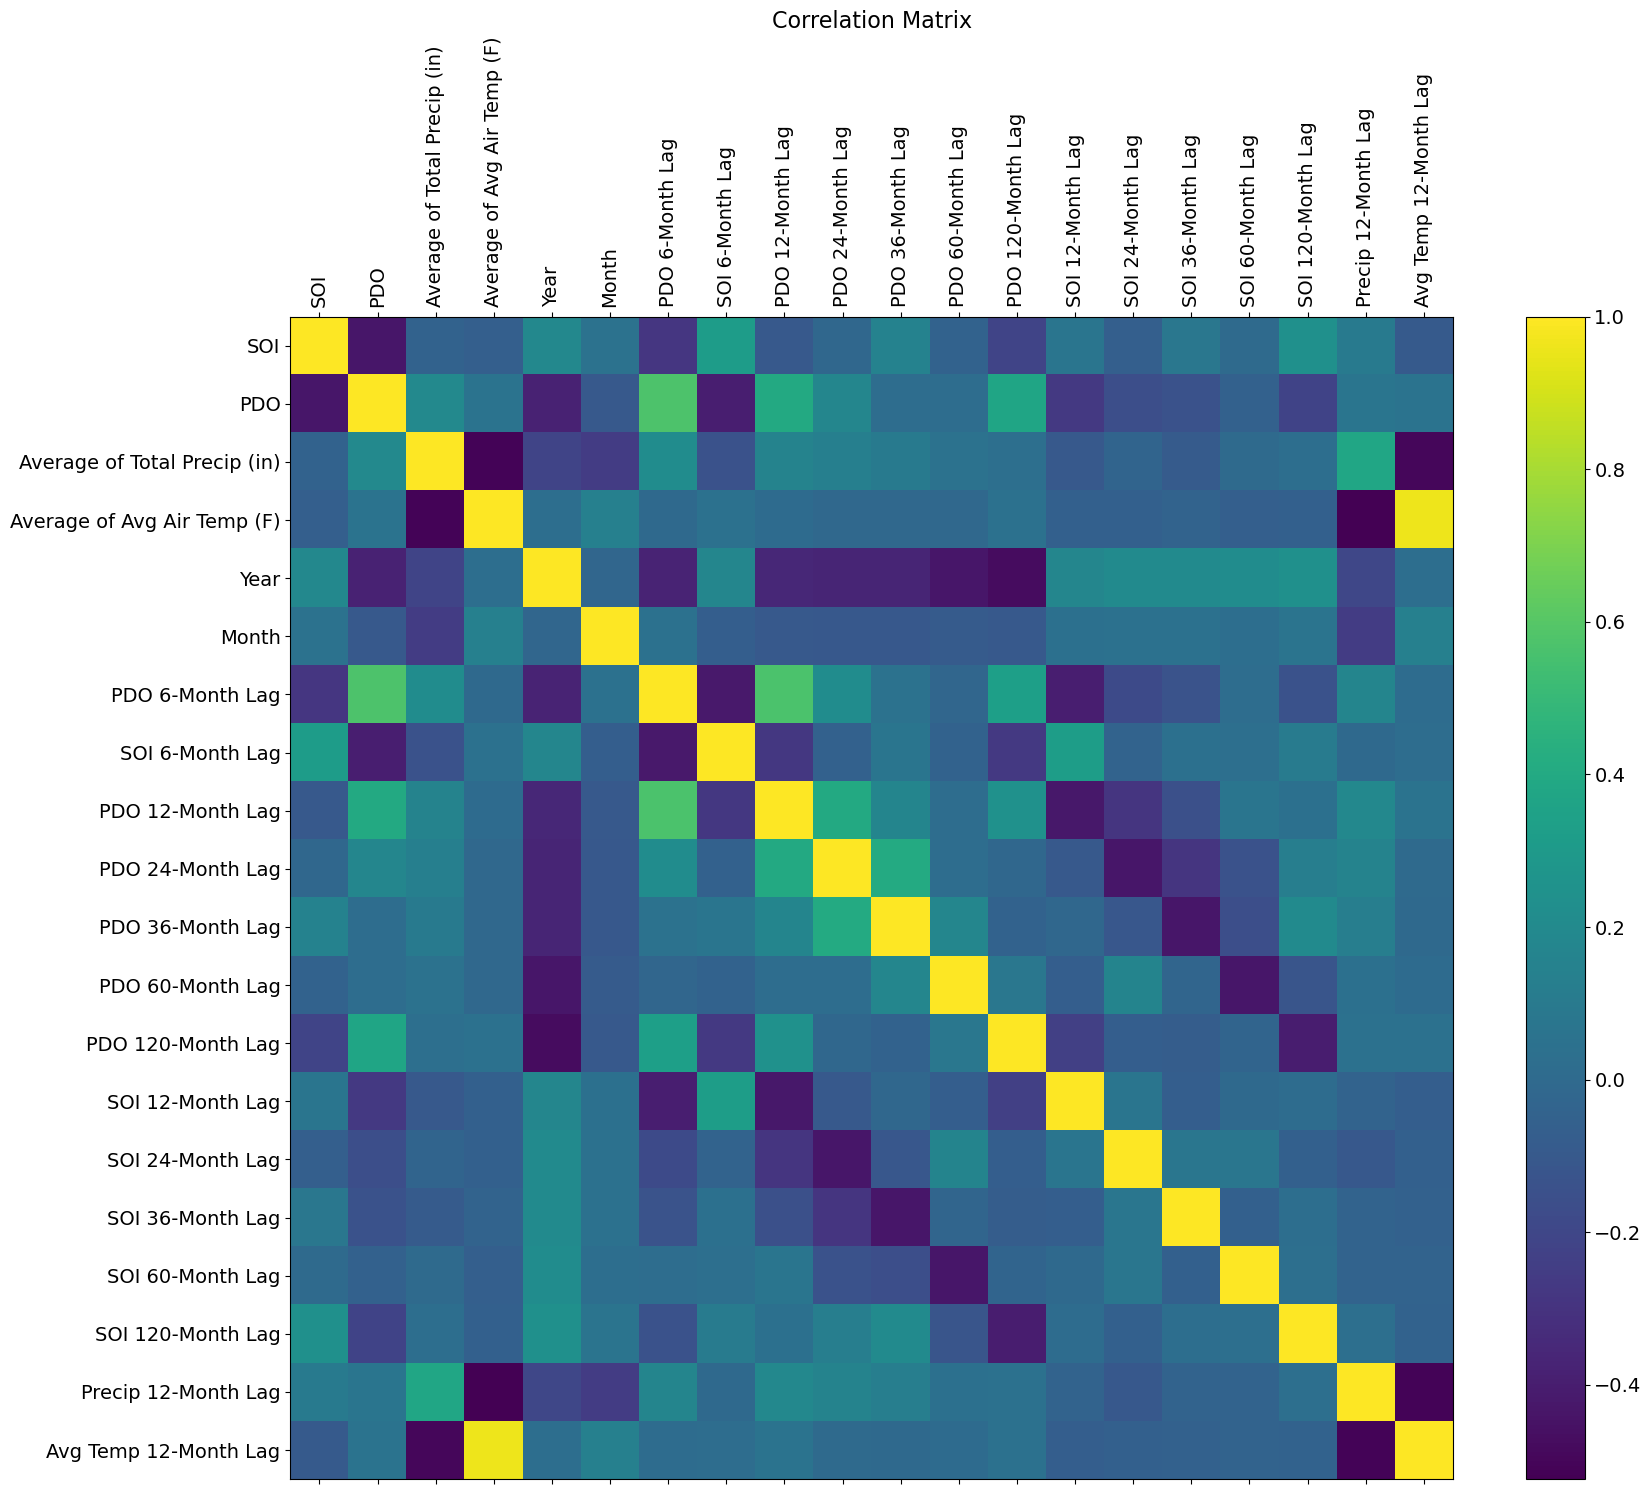

In [39]:
# now we can finally plot the lagged correlations! ^^
f = plt.figure(figsize = (19, 15))
plt.matshow(cor_matrix, fignum = f.number)
plt.xticks(range(training.select_dtypes(['number']).shape[1]), training.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(training.select_dtypes(['number']).shape[1]), training.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.title('Correlation Matrix', fontsize = 16)
plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\corr_fig.png')

# enought of mental gymnastics. now let's do some linear algebra
# the problem has now become a least-square problem:
# I am trying to solve this equation X*b = y where X = ['PDO', 'SOI'], y = ['precip', 'temp'], assuming that there is a linear relationship between X and y. 
# However, I know it will not have a solution, so intead I will try to to minimize ||X'b - y||
# Which makes it a least-squares problem
# Now there are numerous ways of solving the least-squares problem - I think the most straight-forward way to do it is to use the linear solve of numpy

             SOI    PDO  Average of Total Precip (in)  \
2021-01-01  1.64 -0.562                      2.258095   
2021-02-01  1.02 -0.871                      0.361905   
2021-03-01 -0.20 -1.332                      0.844762   
2021-04-01  0.30 -1.439                      0.096667   
2021-05-01  0.49 -1.616                      0.006667   
2021-06-01  0.22 -1.655                      0.001905   
2021-07-01  1.61 -1.573                      0.012857   
2021-08-01  0.27 -0.777                      0.004286   
2021-09-01  0.86 -1.626                      0.014286   
2021-10-01  0.51 -2.683                      1.890000   
2021-11-01  1.12 -2.469                      0.285238   
2021-12-01  1.43 -2.419                      3.110000   
2022-01-01  0.34 -2.052                      0.068095   
2022-02-01  0.76 -1.584                      0.133810   
2022-03-01  1.35 -1.361                      0.920000   
2022-04-01  2.69 -1.805                      0.415714   
2022-05-01  1.90 -2.033        

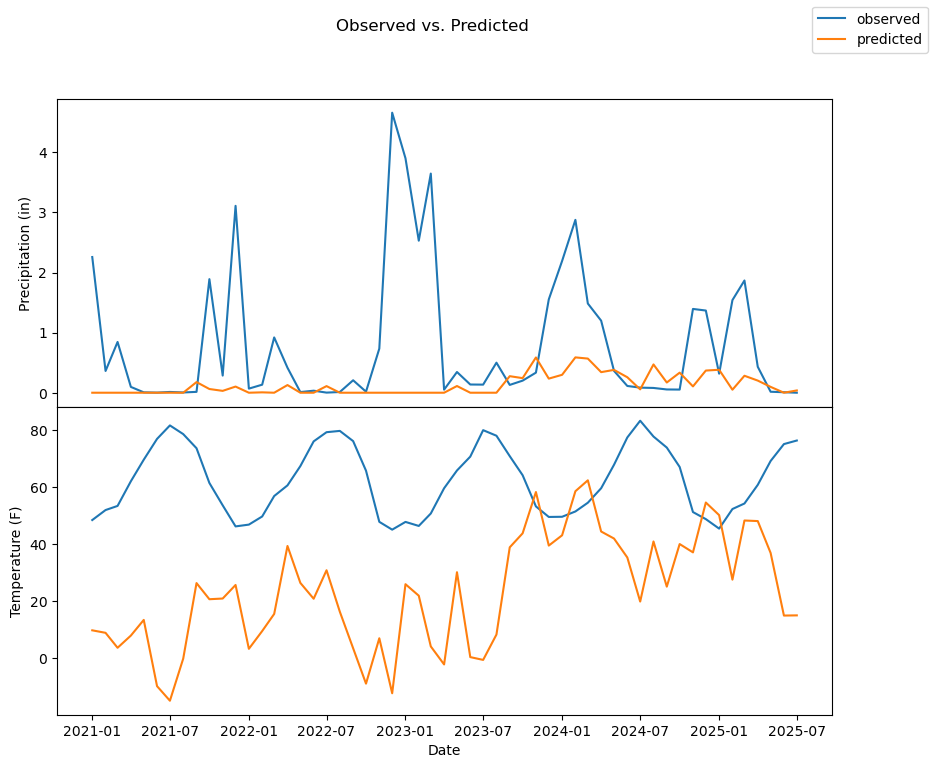

C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\3491018448.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_precip = float(r_squared[:,0])
C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\3491018448.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_temp = float(r_squared[:,1])


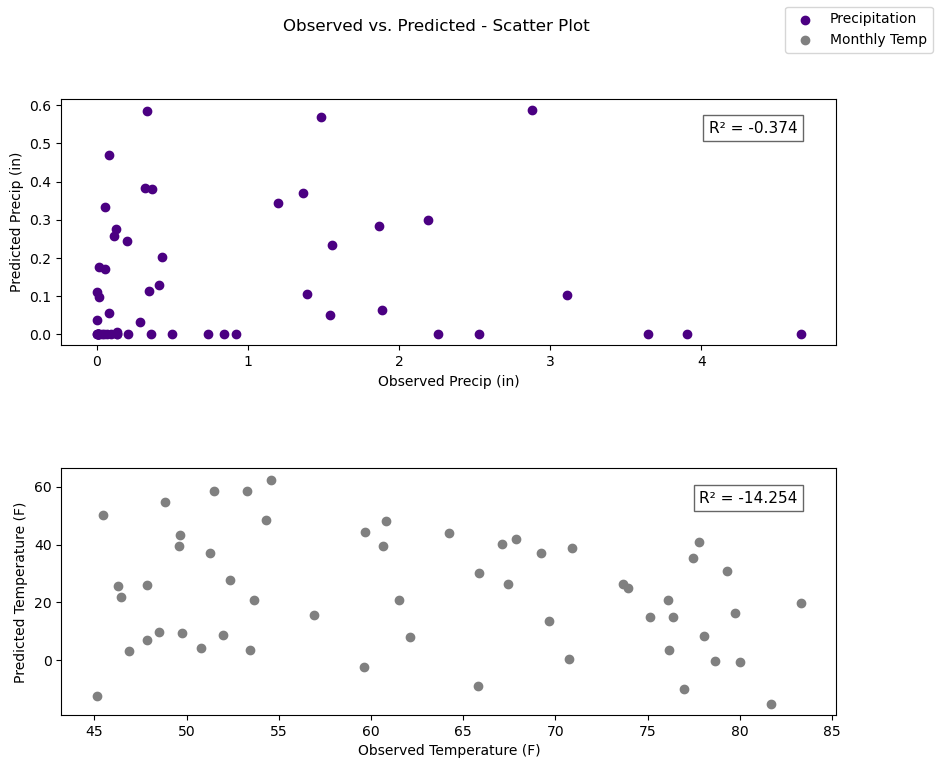

In [26]:
# Staging Area - define X, b, and y
training_clean = training.dropna()
X = np.array(training_clean[['PDO 6-Month Lag', 'SOI 6-Month Lag']])
y = np.array(training_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])
validation_clean = validation.dropna()
X_validation = np.array(validation_clean[['PDO 6-Month Lag', 'SOI 6-Month Lag']])
y_validation = np.array(validation_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])


print(validation_clean)

# now solve
b, residuals, rank, s = np.linalg.lstsq(X, y, rcond= None)

# moment of truth
print({'b':b,
       'residuals':residuals,
       'rank':rank,
       'singular value':s       
      }
)

# plot predicted data with orignial precip
y_hat = np.dot(X_validation, b)
# precipication cannot be lower than zero so 
def precip_correction(arr):
    arr = arr.copy()
    arr[:, 0] = np.where(arr[:, 0] < 0, 0, arr[:, 0])
    return arr

y_hat_corrected = precip_correction(y_hat)
# y_hat_corrected = y_hat

predicted_precip, predicted_temp = zip(*y_hat_corrected)
validation_clean['predicted_precip'] = np.array(predicted_precip)
validation_clean['predicted_temp'] = np.array(predicted_temp)
observed_precip, observed_temp = zip(*y_validation)
observed_precip = np.array(observed_precip)
observed_temp = np.array(observed_temp)

# calculate R squared
y_mean = np.mean(y_validation, axis = 0)
y_mean_array = np.tile(y_mean, (len(y_validation), 1))
y_neg_mean = y_validation - y_mean_array
tss = np.diagonal(np.dot(y_neg_mean.T, y_neg_mean))
r = y_validation - y_hat_corrected
rss = np.diagonal(np.dot(r.T, r))
r_squared = np.ones([1,2]) - rss/tss
print(r_squared[:,1])

# plot predicted againts observed
import matplotlib.dates as mdates
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted')
ax1.plot(validation_clean.index, observed_precip, label = 'observed')
ax1.plot(validation_clean.index, predicted_precip, label = 'predicted')
# ax1.xaxis.set_major_locator(mdates.YearLocator(5))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_ylabel('Precipitation (in)')
ax1.set_xlabel('Date')
ax2.plot(validation_clean.index, observed_temp)
ax2.plot(validation_clean.index, predicted_temp)
# ax2.xaxis.set_major_locator(mdates.YearLocator(5))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_ylabel('Temperature (F)')
ax2.set_xlabel('Date')
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\index_pred_timeseries.png')
plt.show()

# then --- rival - scatter plot for observed vs. predicted and display r -squared
import matplotlib.dates as mdates
rsqrt_precip = float(r_squared[:,0])
rsqrt_temp = float(r_squared[:,1])
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0.5, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted - Scatter Plot')
ax1.scatter(observed_precip, predicted_precip, label = 'Precipitation', color = 'indigo')
ax1.set_ylabel('Predicted Precip (in)')
ax1.set_xlabel('Observed Precip (in)')
ax2.scatter(observed_temp, predicted_temp, label = 'Monthly Temp', color = 'grey')
ax2.set_ylabel('Predicted Temperature (F)')
ax2.set_xlabel('Observed Temperature (F)')
plt.text(0.95, 2.35, f"R² = {rsqrt_precip:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
plt.text(0.95, 0.85, f"R² = {rsqrt_temp:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\index_pred_corr.png')
plt.show()

# Worse than flat line

             SOI    PDO  Average of Total Precip (in)  \
2021-01-01  1.64 -0.562                      2.258095   
2021-02-01  1.02 -0.871                      0.361905   
2021-03-01 -0.20 -1.332                      0.844762   
2021-04-01  0.30 -1.439                      0.096667   
2021-05-01  0.49 -1.616                      0.006667   
2021-06-01  0.22 -1.655                      0.001905   
2021-07-01  1.61 -1.573                      0.012857   
2021-08-01  0.27 -0.777                      0.004286   
2021-09-01  0.86 -1.626                      0.014286   
2021-10-01  0.51 -2.683                      1.890000   
2021-11-01  1.12 -2.469                      0.285238   
2021-12-01  1.43 -2.419                      3.110000   
2022-01-01  0.34 -2.052                      0.068095   
2022-02-01  0.76 -1.584                      0.133810   
2022-03-01  1.35 -1.361                      0.920000   
2022-04-01  2.69 -1.805                      0.415714   
2022-05-01  1.90 -2.033        

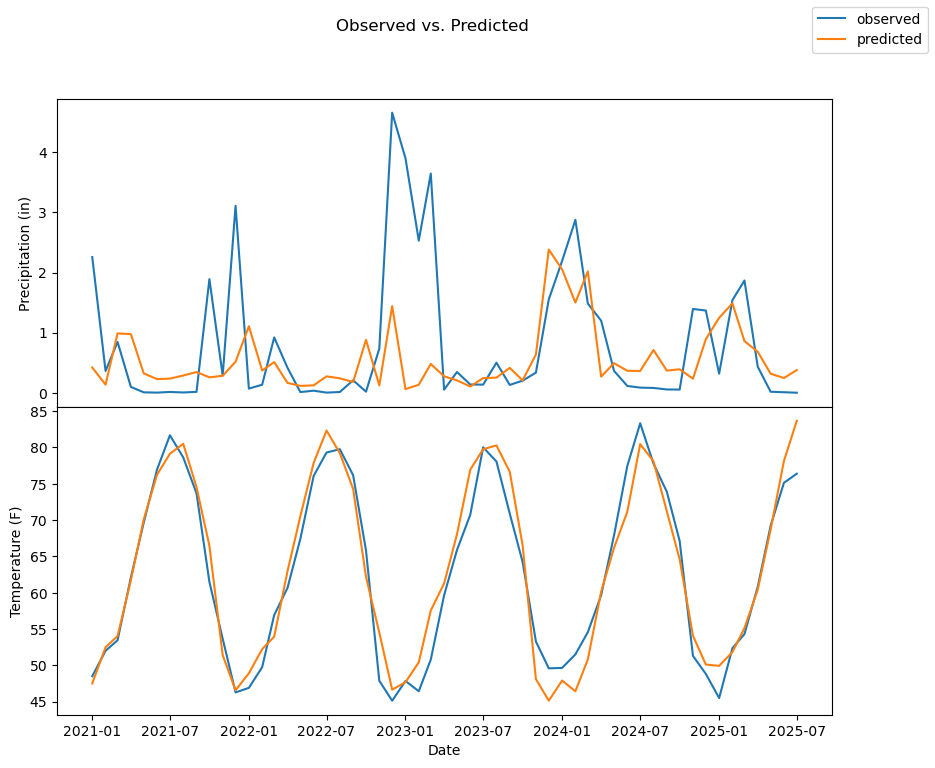

C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\22665302.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_precip = float(r_squared[:,0])
C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\22665302.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_temp = float(r_squared[:,1])


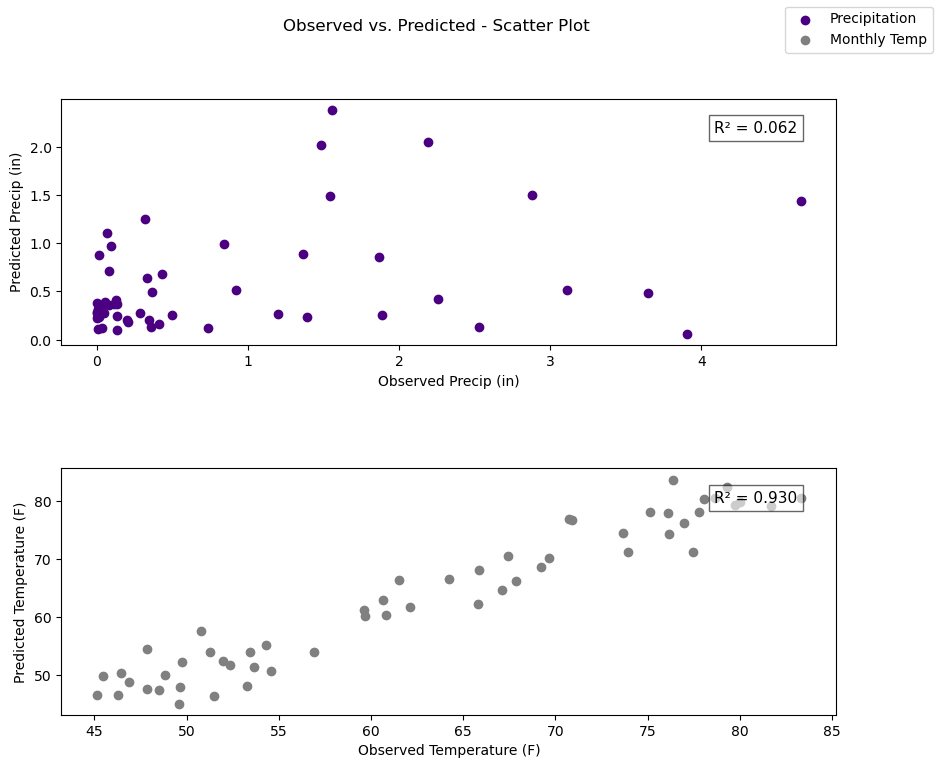

In [27]:
# Staging Area - define X, b, and y, now adding two more predictors - previous year's precipitation and temperature
training_clean = training.dropna()
X = np.array(training_clean[['PDO 6-Month Lag', 'SOI 6-Month Lag', 'Precip 12-Month Lag', 'Avg Temp 12-Month Lag']])
y = np.array(training_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])
validation_clean = validation.dropna()
X_validation = np.array(validation_clean[['PDO 6-Month Lag', 'SOI 6-Month Lag', 'Precip 12-Month Lag', 'Avg Temp 12-Month Lag']])
y_validation = np.array(validation_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])

print(validation_clean)

# now solve
b, residuals, rank, s = np.linalg.lstsq(X, y, rcond= None)

# moment of truth
print({'b':b,
       'residuals':residuals,
       'rank':rank,
       'singular value':s       
      }
)

# plot predicted data with orignial precip
y_hat = np.dot(X_validation, b)
# precipication cannot be lower than zero so 
def precip_correction(arr):
    arr = arr.copy()
    arr[:, 0] = np.where(arr[:, 0] < 0, 0, arr[:, 0])
    return arr

y_hat_corrected = precip_correction(y_hat)

predicted_precip, predicted_temp = zip(*y_hat_corrected)
validation_clean['predicted_precip'] = np.array(predicted_precip)
validation_clean['predicted_temp'] = np.array(predicted_temp)
observed_precip, observed_temp = zip(*y_validation)
observed_precip = np.array(observed_precip)
observed_temp = np.array(observed_temp)

# calculate R squared
y_mean = np.mean(y_validation, axis = 0)
y_mean_array = np.tile(y_mean, (len(y_validation), 1))
y_neg_mean = y_validation - y_mean_array
tss = np.diagonal(np.dot(y_neg_mean.T, y_neg_mean))
r = y_validation - y_hat_corrected
rss = np.diagonal(np.dot(r.T, r))
r_squared = np.ones([1,2]) - rss/tss
print(r_squared[:,1])

# plot predicted againts observed
import matplotlib.dates as mdates
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted')
ax1.plot(validation_clean.index, observed_precip, label = 'observed')
ax1.plot(validation_clean.index, predicted_precip, label = 'predicted')
# ax1.xaxis.set_major_locator(mdates.YearLocator(5))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_ylabel('Precipitation (in)')
ax1.set_xlabel('Date')
ax2.plot(validation_clean.index, observed_temp)
ax2.plot(validation_clean.index, predicted_temp)
# ax2.xaxis.set_major_locator(mdates.YearLocator(5))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_ylabel('Temperature (F)')
ax2.set_xlabel('Date')
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\index_temp_precip_predict_timeseries.png')
plt.show()

# then --- rival - scatter plot for observed vs. predicted and display r -squared
import matplotlib.dates as mdates
rsqrt_precip = float(r_squared[:,0])
rsqrt_temp = float(r_squared[:,1])
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0.5, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted - Scatter Plot')
ax1.scatter(observed_precip, predicted_precip, label = 'Precipitation', color = 'indigo')
ax1.set_ylabel('Predicted Precip (in)')
ax1.set_xlabel('Observed Precip (in)')
ax2.scatter(observed_temp, predicted_temp, label = 'Monthly Temp', color = 'grey')
ax2.set_ylabel('Predicted Temperature (F)')
ax2.set_xlabel('Observed Temperature (F)')
plt.text(0.95, 2.35, f"R² = {rsqrt_precip:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
plt.text(0.95, 0.85, f"R² = {rsqrt_temp:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\index_temp_precip_predict_corr.png')
plt.show()

# better than flat line

             SOI    PDO  Average of Total Precip (in)  \
2021-01-01  1.64 -0.562                      2.258095   
2021-02-01  1.02 -0.871                      0.361905   
2021-03-01 -0.20 -1.332                      0.844762   
2021-04-01  0.30 -1.439                      0.096667   
2021-05-01  0.49 -1.616                      0.006667   
2021-06-01  0.22 -1.655                      0.001905   
2021-07-01  1.61 -1.573                      0.012857   
2021-08-01  0.27 -0.777                      0.004286   
2021-09-01  0.86 -1.626                      0.014286   
2021-10-01  0.51 -2.683                      1.890000   
2021-11-01  1.12 -2.469                      0.285238   
2021-12-01  1.43 -2.419                      3.110000   
2022-01-01  0.34 -2.052                      0.068095   
2022-02-01  0.76 -1.584                      0.133810   
2022-03-01  1.35 -1.361                      0.920000   
2022-04-01  2.69 -1.805                      0.415714   
2022-05-01  1.90 -2.033        

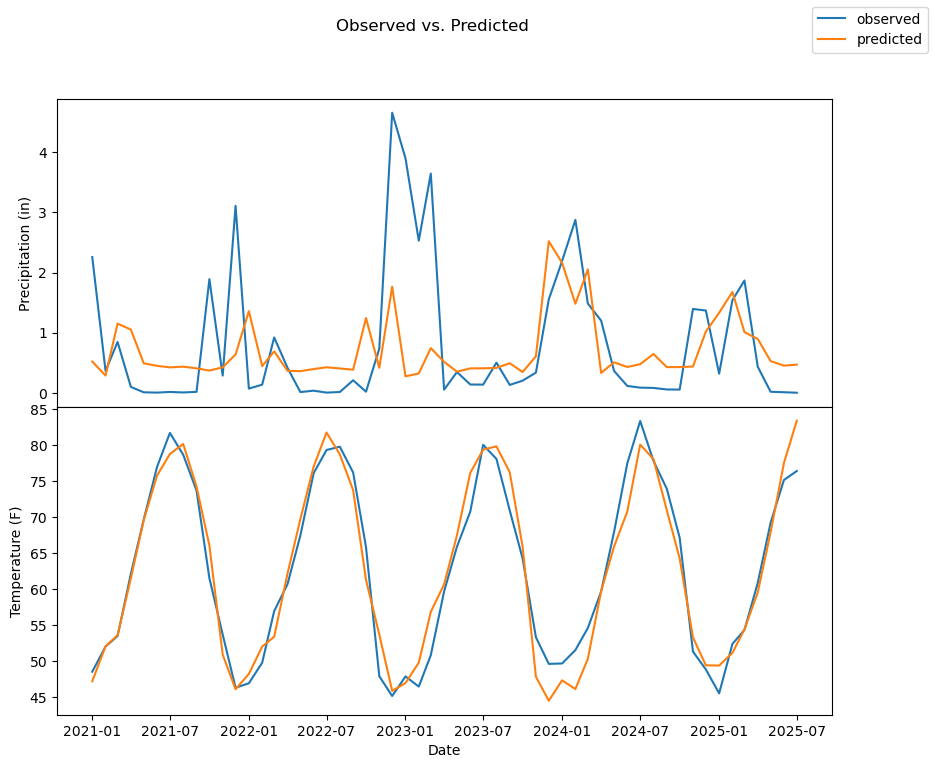

C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\1087380917.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_precip = float(r_squared[:,0])
C:\Users\lisaw\AppData\Local\Temp\ipykernel_35412\1087380917.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rsqrt_temp = float(r_squared[:,1])


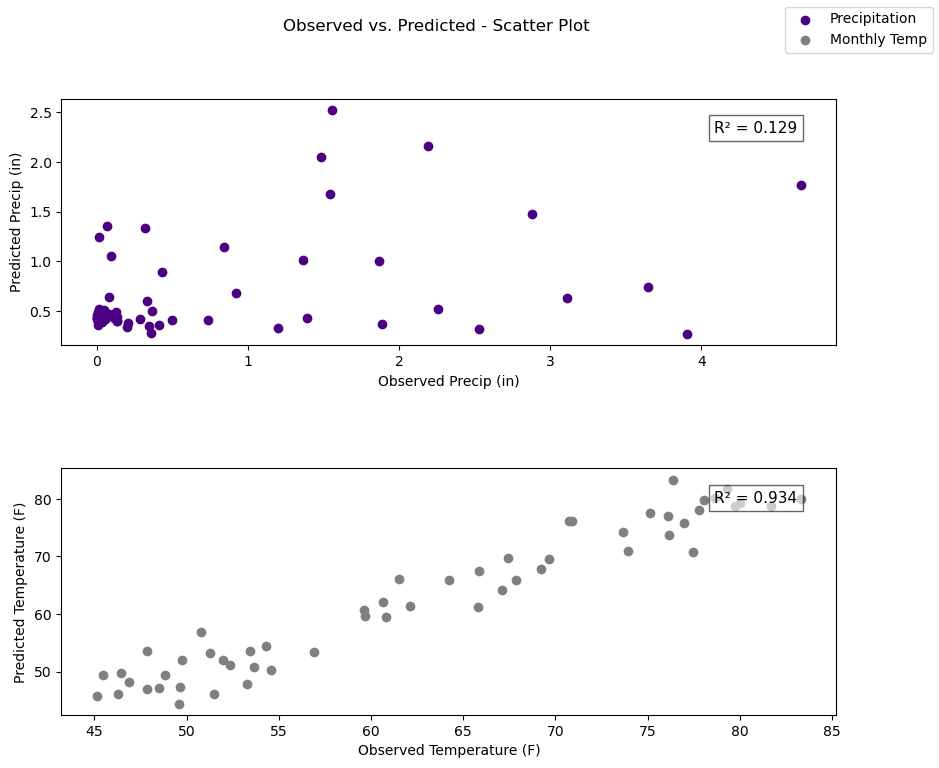

In [28]:
# Staging Area - define X, b, and y, now with only previous year's precipitation and temperature
training_clean = training.dropna()
X = np.array(training_clean[['Precip 12-Month Lag', 'Avg Temp 12-Month Lag']])
y = np.array(training_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])
validation_clean = validation.dropna()
X_validation = np.array(validation_clean[['Precip 12-Month Lag', 'Avg Temp 12-Month Lag']])
y_validation = np.array(validation_clean[['Average of Total Precip (in)', 'Average of Avg Air Temp (F)']])


print(validation_clean)

# now solve
b, residuals, rank, s = np.linalg.lstsq(X, y, rcond= None)

# moment of truth
print({'b':b,
       'residuals':residuals,
       'rank':rank,
       'singular value':s       
      }
)

# plot predicted data with orignial precip
y_hat = np.dot(X_validation, b)
# precipication cannot be lower than zero so 
def precip_correction(arr):
    arr = arr.copy()
    arr[:, 0] = np.where(arr[:, 0] < 0, 0, arr[:, 0])
    return arr

y_hat_corrected = precip_correction(y_hat)

predicted_precip, predicted_temp = zip(*y_hat_corrected)
validation_clean['predicted_precip'] = np.array(predicted_precip)
validation_clean['predicted_temp'] = np.array(predicted_temp)
observed_precip, observed_temp = zip(*y_validation)
observed_precip = np.array(observed_precip)
observed_temp = np.array(observed_temp)

# calculate R squared
y_mean = np.mean(y_validation, axis = 0)
y_mean_array = np.tile(y_mean, (len(y_validation), 1))
y_neg_mean = y_validation - y_mean_array
tss = np.diagonal(np.dot(y_neg_mean.T, y_neg_mean))
r = y_validation - y_hat_corrected
rss = np.diagonal(np.dot(r.T, r))
r_squared = np.ones([1,2]) - rss/tss
print(r_squared[:,1])

# plot predicted againts observed
import matplotlib.dates as mdates
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted')
ax1.plot(validation_clean.index, observed_precip, label = 'observed')
ax1.plot(validation_clean.index, predicted_precip, label = 'predicted')
# ax1.xaxis.set_major_locator(mdates.YearLocator(5))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_ylabel('Precipitation (in)')
ax1.set_xlabel('Date')
ax2.plot(validation_clean.index, observed_temp)
ax2.plot(validation_clean.index, predicted_temp)
# ax2.xaxis.set_major_locator(mdates.YearLocator(5))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set_ylabel('Temperature (F)')
ax2.set_xlabel('Date')
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\temp_precip_predict_timeseries.png')
plt.show()

# then --- rival - scatter plot for observed vs. predicted and display r -squared
import matplotlib.dates as mdates
rsqrt_precip = float(r_squared[:,0])
rsqrt_temp = float(r_squared[:,1])
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(2, 1, hspace=0.5, wspace=0.5)
ax1, ax2 = gs.subplots()
fig.suptitle('Observed vs. Predicted - Scatter Plot')
ax1.scatter(observed_precip, predicted_precip, label = 'Precipitation', color = 'indigo')
ax1.set_ylabel('Predicted Precip (in)')
ax1.set_xlabel('Observed Precip (in)')
ax2.scatter(observed_temp, predicted_temp, label = 'Monthly Temp', color = 'grey')
ax2.set_ylabel('Predicted Temperature (F)')
ax2.set_xlabel('Observed Temperature (F)')
plt.text(0.95, 2.35, f"R² = {rsqrt_precip:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
plt.text(0.95, 0.85, f"R² = {rsqrt_temp:.3f}",
         transform=plt.gca().transAxes, ha='right', va='bottom',
         fontsize=11, bbox=dict(facecolor='white', alpha=0.6))
fig.legend()
# plt.savefig(r'C:\Users\lisaw\OneDrive\Documents\gradstudies\fall2025\ClimateFeedback\Climate\pics\temp_precip_predict_corr.png')
plt.show()

# way better


# Some thoughs: what about the signs of change?? will positive SOI/PDO of the previous year correspond to positive change or negative?

# Primary conclusion - PDO and SOI indexes are not great predictors, but predictions can be improve through adding previous year's values

# If we are really ambitions, we will make it into a machine learning monster - where I will feed the predicted result back into the system, and produce some kind of feedback to improve the algorithm. I want to stay away from polynomial fit, though... need to think about how to introduce parameteres that allows adjustment. One possibility I think is using neural network. Or, I can add the previous years prior and the previous previous years, and such as such... it will be interesting - THINK BAYESIAN